In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = './'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

PLOTS_DIR = f'{DATA_DIR}/plots'

OUTPUT_DIR = f'{DATA_DIR}/output'
MODEL_CHECKPOINT_DIR = f'{DATA_DIR}/models'

## Base Model

### Preprocessing

In [3]:
import pandas as pd
import numpy as np
from fossil.preprocessing import FossilData, LabelEncoder
from fossil.config import ModelsConfig
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
tqdm.pandas()

In [4]:

train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

In [5]:

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [6]:
rel_feat_cols = [c for c in train_df.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel'])]

relative_cols = [f'rel_{col}' for col in rel_feat_cols]

In [7]:
train_df[relative_cols] = train_df.groupby(['month','year'])[rel_feat_cols].apply(lambda x: x/x.median())
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())

dates_unsorted = [(m, y) for y,m in train_df.groupby(['year', 'month']).groups.keys()]
dates = sorted(dates_unsorted, key=lambda d: (d[1], d[0]))


In [9]:
train_data = train_df.copy()

feature_cols = [c for c in train_data.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel','rel'])]

fossil_preproc = FossilData()
train_data = fossil_preproc.base_model_data(train_data, feature_cols, dates)

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

In [10]:

train_data['sku_coded'] = train_data['sku_name'].apply(sku_encoder)
train_data = train_data.groupby(['month','year']).progress_apply(fossil_preproc.clean_data, encoder=sku_encoder).reset_index(drop=True)

  0%|          | 0/58 [00:00<?, ?it/s]

In [11]:

cols_1 = [c for c in train_data.columns if c not in ['sku_name','sku_coded']]
cols_2 = [c for c in train_data.columns if c not in ['month','year', 'sku_name', 'sku_coded']]

train_data[cols_1] = train_data.groupby('sku_name')[cols_1].progress_transform(lambda x: x.fillna(x.median()))
train_data[cols_2] = train_data.groupby(['month','year'])[cols_2].progress_transform(lambda x: x.fillna(x.median()))

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

### Feature Selection using PCA

In [12]:
from sklearn.preprocessing import StandardScaler
features = [c for c in train_data.columns if all(l not in c for l in ['sku_name','sku_coded','target'])] 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train_data[features])

In [13]:
from sklearn.decomposition import PCA

pca = PCA(random_state=ModelsConfig.SEED)
feat_pca = pca.fit(scaled_features)

Text(0, 0.5, 'cumulative explained variance')

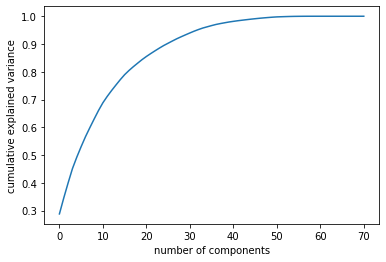

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [15]:
num_components = 50
pca = PCA(num_components, random_state=ModelsConfig.SEED)
feat_pca = pca.fit_transform(scaled_features)

In [16]:
feat_importance = pd.DataFrame(pca.components_, columns = train_data[features].columns)

In [17]:
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = train_data[features].columns
most_important_cols = list(set([initial_feature_names[most_important[i]] for i in range(n_pcs)]))

### Model Training

In [18]:
from fossil.models.gbdt import FossilGBDT

In [19]:
gbdt_models = FossilGBDT()

In [20]:
cols = most_important_cols+['sku_name','sku_coded', 'month', 'year']
feat_cols = [c for c in train_data.columns if c in most_important_cols+['sku_name','sku_coded', 'month', 'year']]
target_cols = [c for c in train_data.columns if 'target' in c]


In [21]:
from itertools import permutations

permutations(feat_cols)

In [22]:
for feature_cols in tqdm(permutations(feat_cols)):
    base_cv_models = gbdt_models.train_model(train_data, list(feature_cols), target_cols, True, 
                                             True, False, model_type=ModelsConfig.BASE_MODEL)
    base_val_mae, base_oof = gbdt_models.test_model(train_data, list(feature_cols), target_cols, base_cv_models)

    target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]
    pred_cols = [f'preds_{i}' for i in range(ModelsConfig.N_STEPS)]

    train_meta = train_data.copy()
    train_meta[pred_cols] = base_oof

    target_arr = train_meta[target_cols].values.reshape(-1,1)
    pred_arr = train_meta[pred_cols].values.reshape(-1,1)

    train_cols = [c for c in train_meta if c not in target_cols+pred_cols]
    train_expanded = train_meta.loc[train_meta.index.repeat(ModelsConfig.N_STEPS)][train_cols].reset_index(drop=True)

    train_expanded['target'] = target_arr
    train_expanded['preds'] = pred_arr
    train_expanded['time_step'] = train_expanded.groupby(['sku_name','month','year']).cumcount()

    meta_dates_unsorted = [(m+ModelsConfig.N_STEPS, y) if m+ModelsConfig.N_STEPS<=12 
                           else (m+ModelsConfig.N_STEPS-12, y+1)
                           for y,m in train_expanded[['year','month']].apply(tuple, axis=1)]

    meta_dates = sorted(meta_dates_unsorted, key=lambda d: (d[1], d[0]))

    train_expanded[['month','year']] = pd.DataFrame(meta_dates, columns=['month','year'])

    cols = ['sku_name','sku_coded','preds', 'time_step', 'month', 'year']
    meta_features = [c for c in train_expanded.columns if 'lag' in c or c in cols]
    meta_targets = 'target'

    meta_cv_models = gbdt_models.train_model(train_expanded, meta_features, meta_targets, False, False, 
                                             False, model_type=ModelsConfig.META_LEARNER,  model_level='meta')
    meta_val_mae, meta_oof = gbdt_models.test_model(train_expanded, meta_features, meta_targets,
                                      meta_cv_models, False, False)
    
    if meta_val_mae == 120218.1111348559:
        break

0it [00:00, ?it/s]

Training model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[239]	training's l1: 113999	valid_1's l1: 155863


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 88194.1	valid_1's l1: 118728
Early stopping, best iteration is:
[675]	training's l1: 79765	valid_1's l1: 117185


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 86117.6	valid_1's l1: 129252
Early stopping, best iteration is:
[673]	training's l1: 78092.4	valid_1's l1: 127827
Elapsed 0.10 mins
--------------------------------------------------


Training model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 83360.2	valid_1's l1: 150188
Early stopping, best iteration is:
[629]	training's l1: 77315.8	valid_1's l1: 148814


Training fold 2
Training until validation sc

KeyboardInterrupt: 

In [63]:
base_val_mae = gbdt_models.test_model(train_data, feature_cols, target_cols, base_cv_models)

Making timestep 1 predictions
Val MAE: 134174.88562959788


Making timestep 2 predictions
Val MAE: 138273.2143390626


Making timestep 3 predictions
Val MAE: 131979.82883817717


Making timestep 4 predictions
Val MAE: 125540.04861937441


Average Val MAE: 132491.99435653837


## Meta Learner

### Data Prep

In [73]:
target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]
pred_cols = [f'preds_{i}' for i in range(ModelsConfig.N_STEPS)]

In [131]:
target_arr = train_data[target_cols].values.reshape(-1,1)
pred_arr = train_data[pred_cols].values.reshape(-1,1)

In [132]:
train_cols = [c for c in train_data if c not in target_cols+pred_cols]
train_expanded = train_data.loc[train_data.index.repeat(ModelsConfig.N_STEPS)][train_cols].reset_index(drop=True)

train_expanded['target'] = target_arr
train_expanded['preds'] = pred_arr
train_expanded['time_step'] = train_expanded.groupby(['sku_name','month','year']).cumcount()

In [133]:
meta_dates_unsorted = [(m+ModelsConfig.N_STEPS, y) if m+ModelsConfig.N_STEPS<=12 
                       else (m+ModelsConfig.N_STEPS-12, y+1)
                       for y,m in train_expanded[['year','month']].apply(tuple, axis=1)]

meta_dates = sorted(meta_dates_unsorted, key=lambda d: (d[1], d[0]))

In [134]:
train_expanded[['month','year']] = pd.DataFrame(meta_dates, columns=['month','year'])

### Model Training

In [135]:
cols = ['sku_name','sku_coded','preds', 'time_step', 'month', 'year']
meta_features = [c for c in train_expanded.columns if 'lag' in c or c in cols]
meta_targets = 'target'

meta_cv_models = gbdt_models.train_model(train_expanded, meta_features, meta_targets, 
                                         False, False, False, 'cat', 'meta')



Training fold 1
0:	learn: 204116.0946040	test: 204116.0946040	test1: 222585.3215166	best: 222585.3215166 (0)	total: 8.83ms	remaining: 1m 28s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 130601.9907
bestIteration = 283

Shrink model to first 284 iterations.
Elapsed 0.06 mins
--------------------------------------------------




Training fold 2
0:	learn: 208442.3634465	test: 208442.3634465	test1: 213303.9329159	best: 213303.9329159 (0)	total: 10.1ms	remaining: 1m 40s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 117399.6913
bestIteration = 325

Shrink model to first 326 iterations.
Elapsed 0.12 mins
--------------------------------------------------




Training fold 3
0:	learn: 217988.8938730	test: 217988.8938730	test1: 194706.5108980	best: 194706.5108980 (0)	total: 8.91ms	remaining: 1m 29s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 112419.2626
bestIteration = 274

Shrink model to first 275 iterations.
Elapsed 0.17 mins


In [136]:
meta_val_mae = gbdt_models.test_model(train_expanded, meta_features, meta_targets,
                                      meta_cv_models, False, False)



Making fold 1 predictions
Val MAE: 130601.99071888498




Making fold 2 predictions
Val MAE: 117399.69131510926




Making fold 3 predictions
Val MAE: 112419.26264950381


Average Val MAE: 120218.1111348559


## Forecasting

### Data Prep

In [164]:

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [165]:
from fossil.config import ModelsConfig
from fossil.preprocessing import FossilData, LabelEncoder

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95).unique())
fossil_preproc = FossilData()

In [166]:
rel_feat_cols = [c for c in train_df.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel'])]

relative_cols = [f'rel_{col}' for col in rel_feat_cols]

In [167]:
train_df[relative_cols] = train_df.groupby(['month','year'])[rel_feat_cols].apply(lambda x: x/x.median())
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [168]:
dates = sorted([(m, y) for y,m in test.groupby(['year', 'month']).groups.keys()], key=lambda d: (d[1], d[0]))

month,yr = dates[0]
test_dates = [(month-n,yr) if month>n else (12+month-n, yr-1) for n in range(1,ModelsConfig.LOOKBACK+1)]

m,y = test_dates[0]
pred_dates = [(m+n,yr) if m+n<=12 else (m+n-12, yr+1) for n in range(1,ModelsConfig.N_STEPS+1)]

test_context = train_df.copy()

In [169]:
from fossil.utils import add_missing_context

test_sku = test.sku_name.unique()
context_sku = test_context[test_context[['month', 'year']].apply(tuple, axis=1).isin(test_dates)].sku_name.unique()

missing_sku = list(set(test_sku).difference(context_sku))
test_context = test_context.groupby(['month','year']).apply(add_missing_context, missing_sku=missing_sku).reset_index(drop=True)

In [170]:
feature_cols = [c for c in test_context.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel','rel'])]

test_data = fossil_preproc.base_model_data(test_context, feature_cols, dates)

test_data['sku_coded'] = test_data['sku_name'].apply(sku_encoder)
test_data = test_data.groupby(['month','year']).progress_apply(fossil_preproc.clean_data, encoder=sku_encoder).reset_index(drop=True)

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [171]:

cols_1 = [c for c in test_data.columns if c not in ['sku_name','sku_coded']]
cols_2 = [c for c in test_data.columns if c not in ['month','year','sku_name','sku_coded']]

test_data[cols_1] = test_data.groupby('sku_name')[cols_1].progress_transform(lambda x: x.fillna(x.median()))
test_data[cols_2] = test_data.groupby(['month','year'])[cols_2].progress_transform(lambda x: x.fillna(x.median()))

  0%|          | 0/3869 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [172]:
test_data = test_data[test_data[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

### Making Predictions

In [173]:
target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]

non_features = ['sku_name','sku_coded']+target_cols
feature_cols = list(set([c for c in test_data.columns if c not in non_features and c in most_important_cols+['month','year']]))

In [174]:
from fossil.models.gbdt import FossilGBDT
gbdt_models = FossilGBDT()

base_preds = gbdt_models.forecast(test_data, feature_cols, target_cols, base_cv_models, True, True, True)

In [176]:
if ModelsConfig.LOOKBACK>1:
    pred_df = pred_df.groupby(['sku_name','lookback_ix']).mean().reset_index()    

In [177]:
base_preds = base_preds[base_preds.sku_name.isin(test.sku_name.unique())]
pred_arr = base_preds[target_cols].values.reshape(-1,1)

sub_cols = [c for c in train_cols if 'target' not in c]
sub_df = base_preds.loc[base_preds.index.repeat(ModelsConfig.N_STEPS)][sub_cols].reset_index(drop=True)


sub_df['month'] = pd.DataFrame(pred_dates*int(len(sub_df)/ModelsConfig.N_STEPS)).loc[:, 0].values
sub_df['year'] = pd.DataFrame(pred_dates*int(len(sub_df)/ModelsConfig.N_STEPS)).loc[:, 1].values

sub_df['preds'] = pred_arr
sub_df['time_step'] = sub_df.groupby(['sku_name','month','year']).cumcount()

In [179]:
cols = ['preds', 'time_step', 'month', 'year']
meta_features = [c for c in sub_df.columns if 'lag' in c or c in cols]
meta_targets = 'Target'

sub_df = gbdt_models.forecast(sub_df, meta_features, meta_targets, meta_cv_models, True, False, False)

sub_df['Item_ID'] = sub_df['sku_name'].astype(str)+'_'+sub_df['month'].astype(str)+'_'+sub_df['year'].astype(str)

In [181]:
save_name = f'{OUTPUT_DIR}/fossil_lgbm_cat_{meta_val_mae}.csv'
sub_df[['Item_ID','Target']].to_csv(save_name, index=False)